# Time-Series-Forecast

In [60]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# import plotly
import plotly.express as px

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import for time series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

from pathlib import Path
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

from warnings import simplefilter
simplefilter("ignore")

## Importing Data

In [61]:
# import the training data
train = pd.read_csv("data\\train.csv")
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [62]:
test = pd.read_csv("data\\test.csv")
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [63]:
holidays_events = pd.read_csv ("data\\holidays_events.csv")
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [64]:
oil = pd.read_csv ("data\\oil.csv")
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [65]:
stores = pd.read_csv ("data\\stores.csv")
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [66]:
transactions = pd.read_csv ("data\\transactions.csv")
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## 1 Exploratory Analysis

### 1.1 Data overview

In [67]:
# display all the columns in the dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [68]:
train.shape

(3000888, 6)

In [69]:
train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [70]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

### 1.2 Merging datasets

In [71]:
merged_data = train.copy()

# merge dataframes
merged_data = pd.merge(merged_data, stores, on='store_nbr')
merged_data = pd.merge(merged_data, holidays_events, on='date', how='left')
merged_data = pd.merge(merged_data, oil, on='date', how='left')
merged_data = pd.merge(merged_data, transactions, on=['date', 'store_nbr'], how='left')

In [72]:
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,dcoilwtico,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN


In [73]:
# convert date column to datetime
train['date'] = pd.to_datetime(train['date'])

# set date column as index
train.set_index('date', inplace=True)

## 2 Missing values

In [74]:
# display all the missing values
train[train.isnull().any(axis=1)] # no missing values

,id,store_nbr,family,sales,onpromotion
date,,,,,


In [75]:
# display all the columns with missing values in holidays_events
holidays_events[holidays_events.isnull().any(axis=1)] # no missing values

,date,type,locale,locale_name,description,transferred


In [76]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [77]:
# display all columns with missing values in oil
oil[oil.isnull().any(axis=1)]

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


In [78]:
# display all columns with missing values in stores
stores[stores.isnull().any(axis=1)]

,store_nbr,city,state,type,cluster


In [79]:
# display all columns with missing values in transactions
transactions[transactions.isnull().any(axis=1)]

,date,store_nbr,transactions


In [80]:
# display the missing values in merged dataframe
merged_data.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type_x                0
cluster               0
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       955152
transactions     249117
dtype: int64

### 2.1 Handling missing values in Oil

In [81]:
# use backward fill
oil.fillna(method='bfill', inplace=True)

In [82]:
# display all columns with missing values in oil
oil[oil.isnull().any(axis=1)]

,date,dcoilwtico


In [83]:
merged_data.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type_x                0
cluster               0
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       955152
transactions     249117
dtype: int64

## 3 Outliers

In [84]:
#train['log_sales'] = np.log(train['sales'])

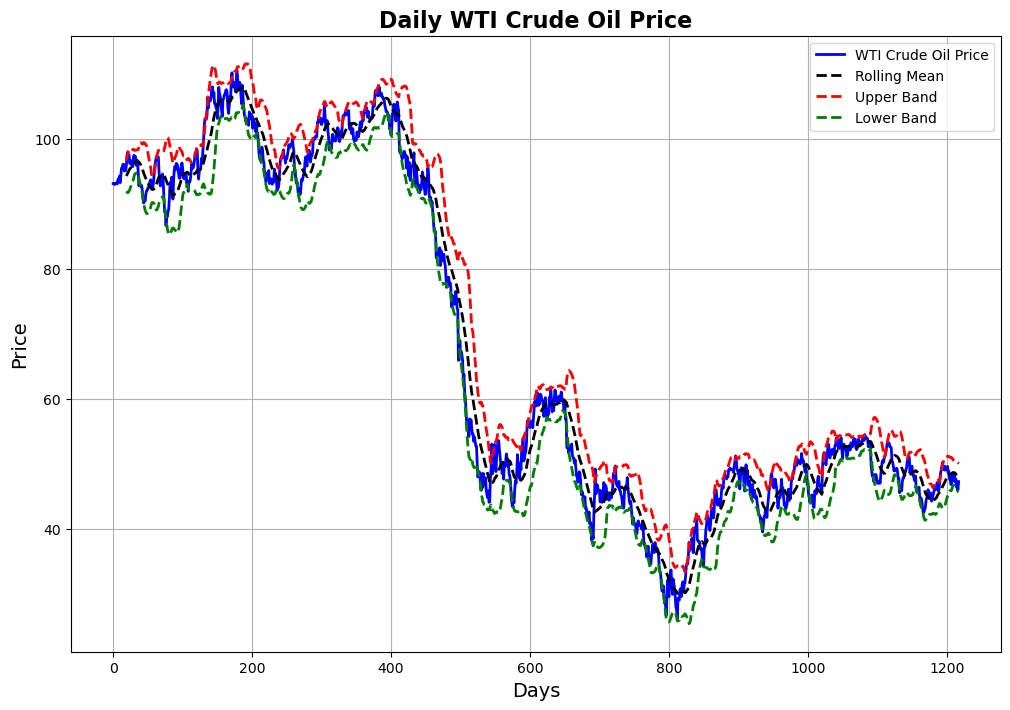

In [85]:
# outlier detection using bollinger bands
oil['rolling_mean'] = oil['dcoilwtico'].rolling(window=20).mean()
oil['rolling_std'] = oil['dcoilwtico'].rolling(window=20).std()
oil['upper_band'] = oil['rolling_mean'] + (oil['rolling_std'] * 2)
oil['lower_band'] = oil['rolling_mean'] - (oil['rolling_std'] * 2)

plt.figure(figsize=(12, 8))
plt.plot(oil['dcoilwtico'], color='blue', linestyle='-', linewidth=2, label='WTI Crude Oil Price')
plt.plot(oil['rolling_mean'], color='black', linestyle='--', linewidth=2, label='Rolling Mean')
plt.plot(oil['upper_band'], color='red', linestyle='--', linewidth=2, label='Upper Band')
plt.plot(oil['lower_band'], color='green', linestyle='--', linewidth=2, label='Lower Band')
plt.title('Daily WTI Crude Oil Price', fontsize=16, fontweight='bold')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()